In [114]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline
from utils_project import compute_jacobian_and_bias,compute_bias, check_bias
from data.data import gen_signal
# three outputs from this function: signal [num_samples, 2, signal_dim]; frequency (float)[num_samples, num_freq];
# num_freq:int [num_samples] 
from data.noise import noise_torch
from data import fr
# find nearest
def find_neariest_idx(signal_fr, xgrid):
    indices = []
    for i in signal_fr:
        idx = np.argmin(np.abs(i - xgrid))
        indices.append(idx)
    return indices

In [6]:
fr_path = 'checkpoint/model_snr_30_bias_no/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_30_bias_no/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fr_module.cpu()
fr_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [5]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)
idx = 8
inp = torch.as_tensor(signal_10dB[idx][None])

In [4]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
bias = compute_bias(jacobian, inputs, outputs)

In [5]:
fft_filter = jacobian[0] + 1j * jacobian[1]
bias = bias.reshape(-1)

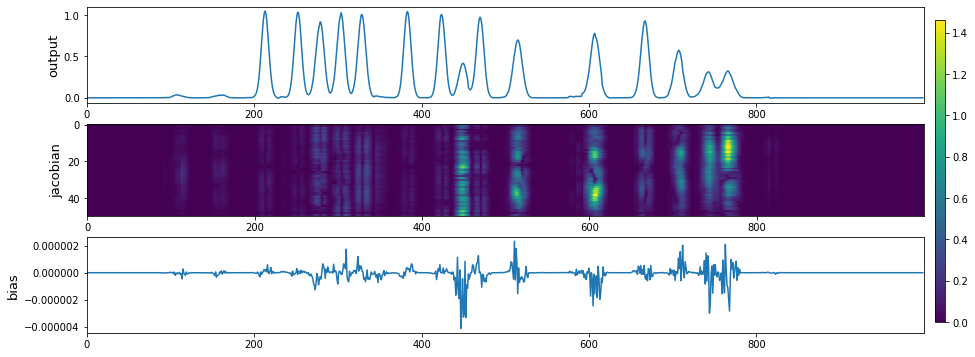

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(fft_filter))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias)
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [78]:
# hyper parameter setting
num_samples=10
signal_dim=50
min_sep=1.
snr=30
fixed_freq = [0.4] # set None for  random frequency
num_freq=len(fixed_freq)

In [103]:
import matplotlib.backends.backend_pdf


In [115]:
def generate_report_plots(num_samples=2, signal_dim=50, min_sep=1., snr=30, fixed_freq=[0.4], save=False):
    if not os.path.exists('./plots'):
        os.mkdir('./plots')
    save_dir = './plots'
    num_freq = len(fixed_freq)
    for signal_idx in range(num_samples):
        clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                             signal_dim=signal_dim, 
                                                             num_freq=num_freq, min_sep=min_sep,
                                                            fixed_freq=fixed_freq)
        noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')

        clean_signal, signal_fr, signal_num_freq = clean_signals[signal_idx], signal_frs[signal_idx], signal_num_freqs[signal_idx]
        noisy_signal = noisy_signals[signal_idx].cpu().numpy()
        clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
        clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
        clean_signal_fft = np.fft.fftshift(clean_signal_fft)
        noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
        noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
        noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)
        noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)
        jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)
        fft_filter = jacobian[0] - 1j * jacobian[1]
        
        
        # plot 1
        fig1, ax = plt.subplots(3, 1, figsize=(15, 6))
        xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
        ax[0].plot(xgrid, outputs[0])
        ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
        ylim = ax[0].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[0].legend()
        ax[0].set_xlim(-0.5, 0.5)
        ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
        ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
        ax[1].set_xlim(-0.5, 0.5)
        ylim = ax[1].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[1].legend()
        im = ax[2].imshow(np.abs(fft_filter))
        ax[2].set_aspect(2.2)
        ax[2].set_ylabel('jacobian', fontsize=13)

        fig1.subplots_adjust(right=0.9)
        cbar_ax = fig1.add_axes([0.91, 0.15, 0.01, 0.7])
        fig1.colorbar(im, cax=cbar_ax)
        plt.show()
        # plot 2
        fig2, ax = plt.subplots(3, 1, figsize=(15, 6))
        xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
        ax[0].plot(xgrid, outputs[0])
        ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
        ylim = ax[0].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[0].legend()

        ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
        ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
        ylim = ax[1].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[1].legend()
        fft_filter_norm = fft_filter * np.conjugate(fft_filter)
        fft_filter_norm = fft_filter_norm.T.sum(axis=1).real
        ax[2].plot(xgrid, fft_filter_norm)
        ax[0].set_xlim(-0.5, 0.5)
        ax[1].set_xlim(-0.5, 0.5)
        ax[2].set_xlim(-0.5, 0.5)

        fig2.subplots_adjust(right=0.9)
        plt.show()
        
        # plot. 3
        indices = find_neariest_idx(signal_fr, xgrid)
        target_filter = fft_filter.T[indices]
        # time domain
        fig3, ax = plt.subplots(target_filter.shape[0], 2)
        for idx, filt in enumerate(target_filter):
            if target_filter.shape[0] > 1:
                ax[idx, 0].plot(filt.real)
                ax[idx, 1].plot(filt.imag)
                ax[idx, 0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
                ax[idx, 1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
            else:
                ax[0].plot(filt.real)
                ax[1].plot(filt.imag)
                ax[0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
                ax[1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        plt.tight_layout()
        plt.show()
        
        # fft domian of signals
        fig4, ax = plt.subplots(target_filter.shape[0], 1,  dpi=300)
        for idx, filt in enumerate(target_filter):
            filt_fft = np.fft.fft(filt,n=1000)
            filt_fft = np.fft.fftshift(filt_fft)
            magnitude = np.abs(filt_fft)
            if target_filter.shape[0] > 1:
                ax[idx].plot(xgrid, magnitude)
                ax[idx].plot(signal_fr[idx], magnitude[indices[idx]], '*')
                ax[idx].plot(-signal_fr[idx], magnitude[999-indices[idx]], '*')
                ax[idx].set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
            else:
                ax.plot(xgrid, magnitude)
                ax.plot(signal_fr[idx], magnitude[indices[idx]], '*')
                ax.plot(-signal_fr[idx], magnitude[999-indices[idx]], '*')
                ax.set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
        plt.tight_layout()
        plt.show()
        
        if save:
            pdf = matplotlib.backends.backend_pdf.PdfPages("./plots/output_{}.pdf".format(signal_idx))
            pdf.savefig(fig1)            
            pdf.savefig(fig2)
            pdf.savefig(fig3)
            pdf.savefig(fig4)
            pdf.close()

In [79]:
clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                         signal_dim=signal_dim, 
                                                         num_freq=num_freq, min_sep=min_sep,
                                                        fixed_freq=fixed_freq)
noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')
idx = 0
clean_signal, signal_fr, signal_num_freq = clean_signals[idx], signal_frs[idx], signal_num_freqs[idx]
noisy_signal = noisy_signals[idx].cpu().numpy()
print(clean_signal.shape)
clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
clean_signal_fft = np.fft.fftshift(clean_signal_fft)
noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)

(2, 50)


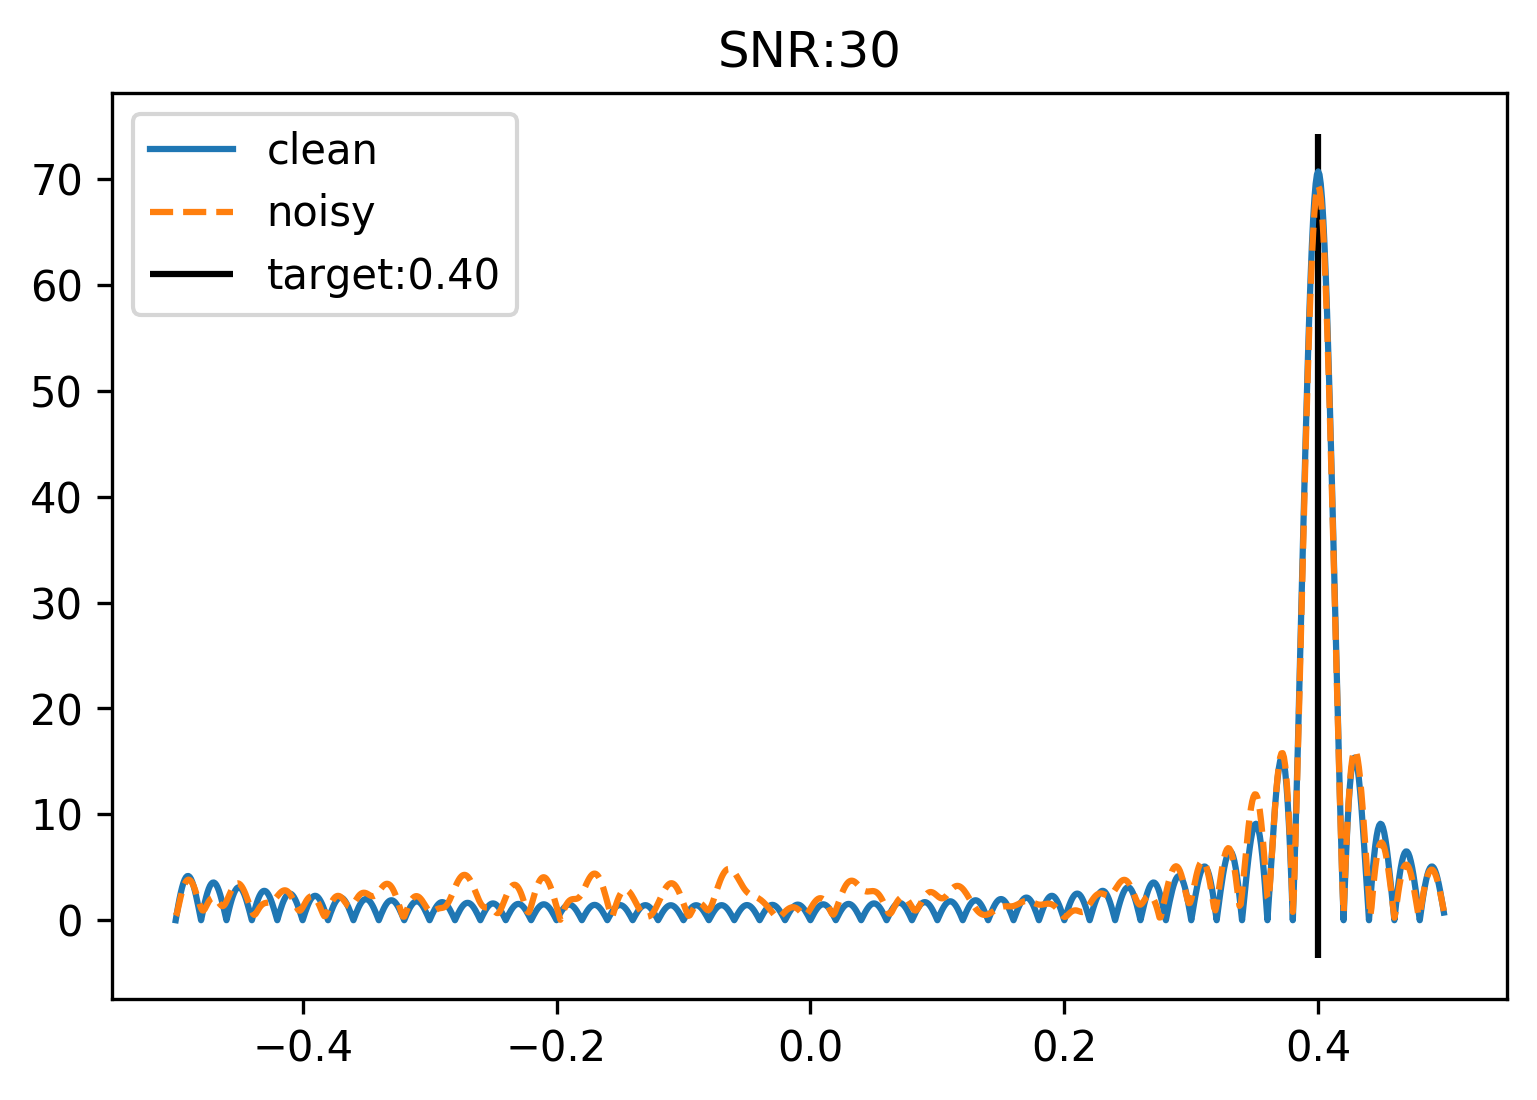

In [100]:
fig, ax = plt.subplots(dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax.plot(xgrid, np.abs(clean_signal_fft),label='clean')
ax.plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy')
ylim = ax.get_ylim()
for i in range(signal_fr.shape[0]):
    ax.vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax.set_title('SNR:{}'.format(snr))
ax.legend()

In [81]:
noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)
jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)


In [82]:
fft_filter = jacobian[0] - 1j * jacobian[1]

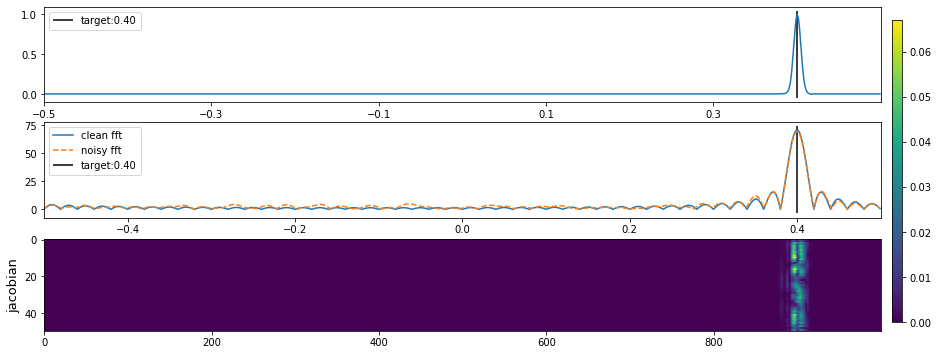

In [86]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[0].legend()
ax[0].set_xlim(-0.5, 0.5)
ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ax[1].set_xlim(-0.5, 0.5)
ylim = ax[1].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[1].legend()
im = ax[2].imshow(np.abs(fft_filter))
ax[2].set_aspect(2.2)
ax[2].set_ylabel('jacobian', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

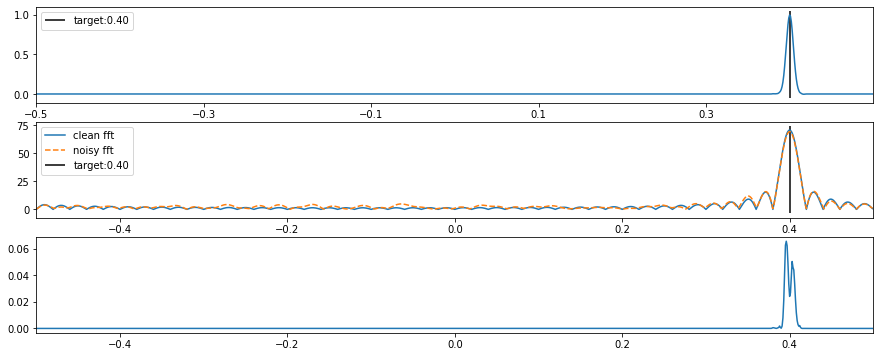

In [87]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[0].legend()

ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ylim = ax[1].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[1].legend()
fft_filter_norm = fft_filter * np.conjugate(fft_filter)
fft_filter_norm = fft_filter_norm.T.sum(axis=1).real
ax[2].plot(xgrid, fft_filter_norm)
ax[0].set_xlim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)
ax[2].set_xlim(-0.5, 0.5)

fig.subplots_adjust(right=0.9)
plt.show()

In [88]:
indices = find_neariest_idx(signal_fr, xgrid)
target_filter = fft_filter.T[indices]

In [91]:
target_filter.shape

(1, 50)

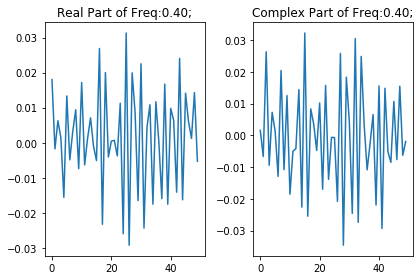

In [93]:
# time domain
fig, ax = plt.subplots(target_filter.shape[0], 2)
for idx, filt in enumerate(target_filter):
    if target_filter.shape[0] > 1:
        ax[idx, 0].plot(filt.real)
        ax[idx, 1].plot(filt.imag)
        ax[idx, 0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        ax[idx, 1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
    else:
        ax[0].plot(filt.real)
        ax[1].plot(filt.imag)
        ax[0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        ax[1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
plt.tight_layout()

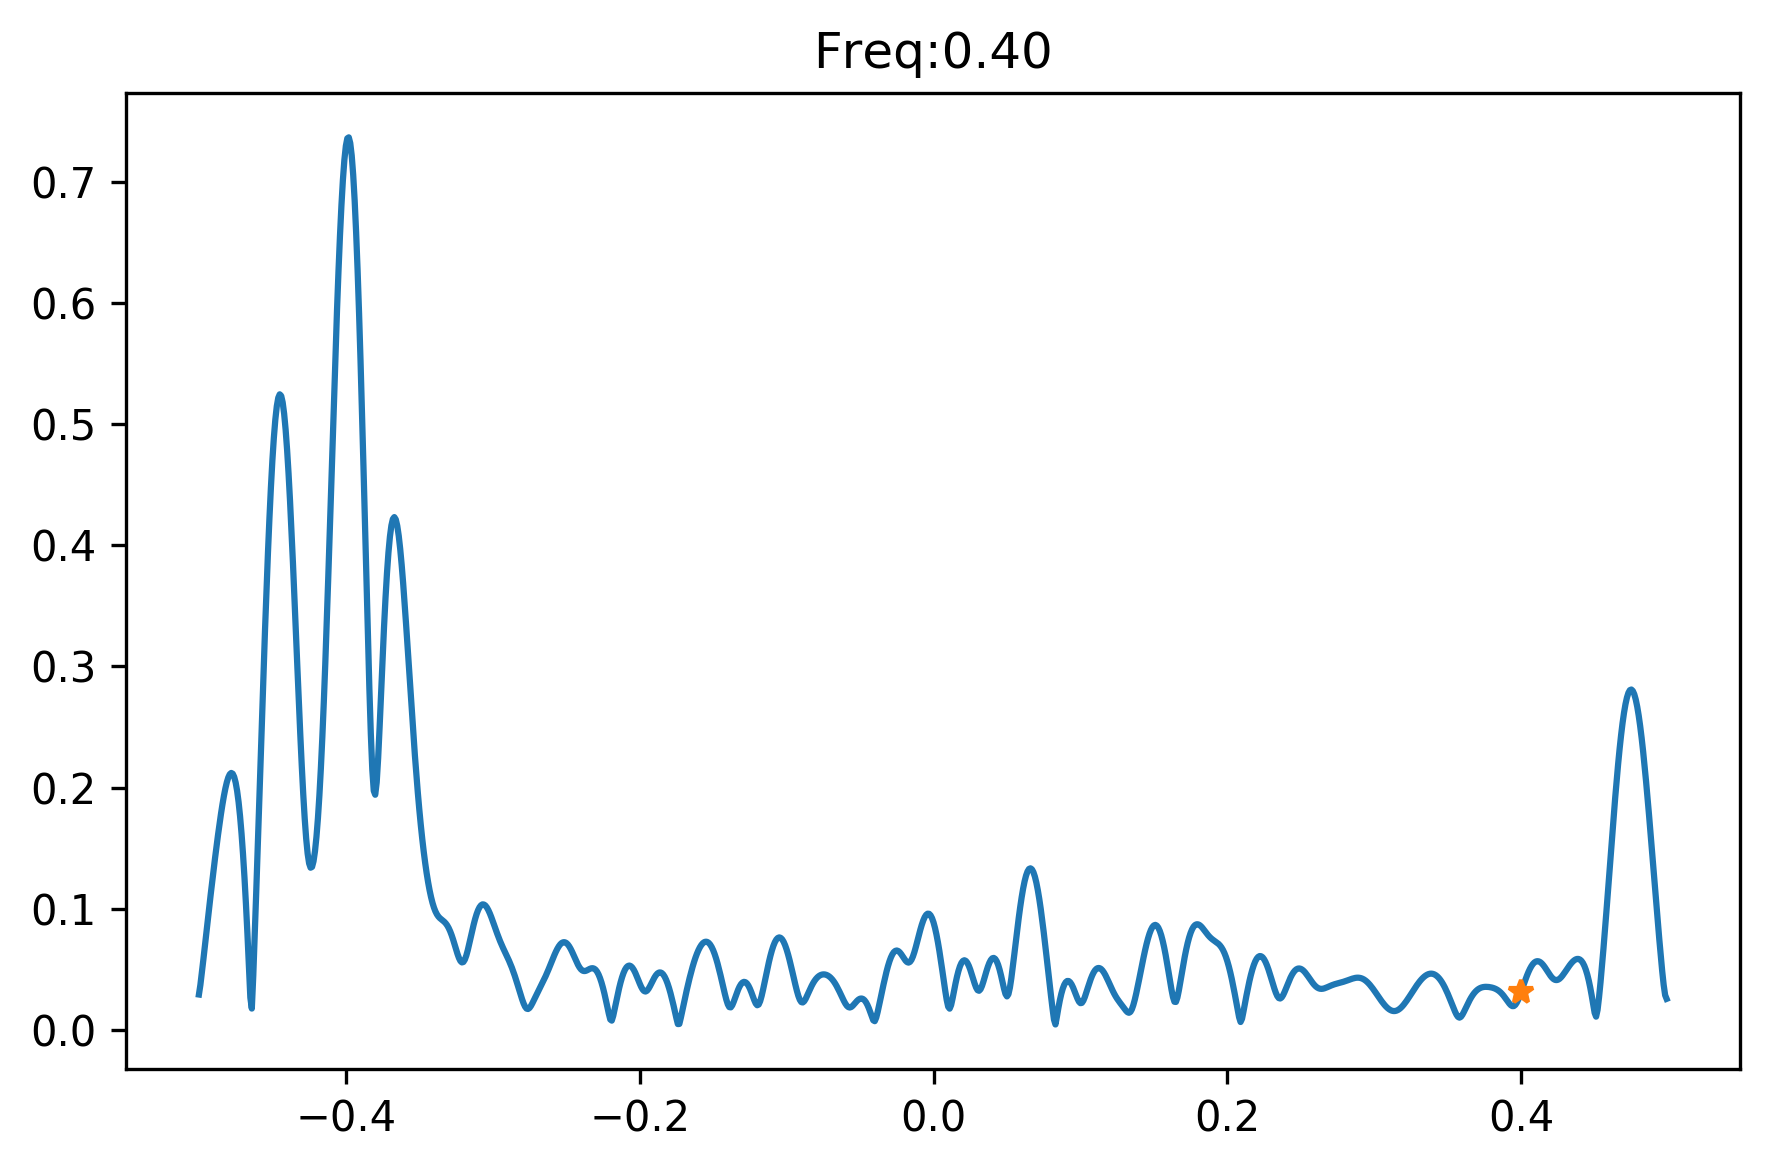

In [98]:
# fft domian of signals
fig, ax = plt.subplots(target_filter.shape[0], 1,  dpi=300)
for idx, filt in enumerate(target_filter):
    filt_fft = np.fft.fft(filt,n=1000)
    filt_fft = np.fft.fftshift(filt_fft)
    magnitude = np.abs(filt_fft)
    if target_filter.shape[0] > 1:
        ax[idx].plot(xgrid, magnitude)
        ax[idx].plot(signal_fr[idx], magnitude[indices[idx]], '*')
        ax[idx].set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
    else:
        ax.plot(xgrid, magnitude)
        ax.plot(signal_fr[idx], magnitude[indices[idx]], '*')
        ax.set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
plt.tight_layout()

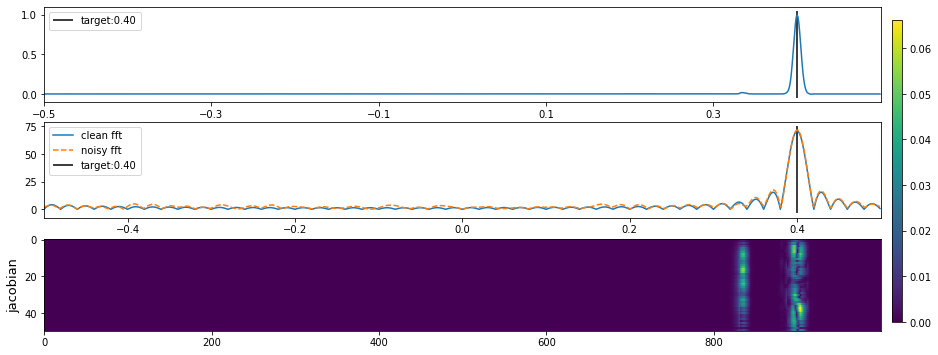

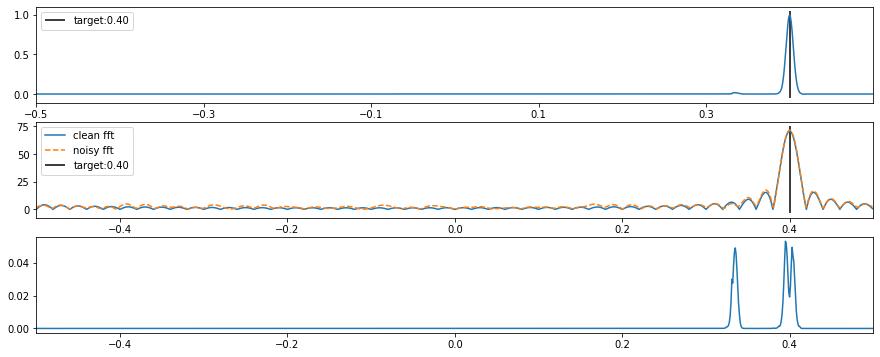

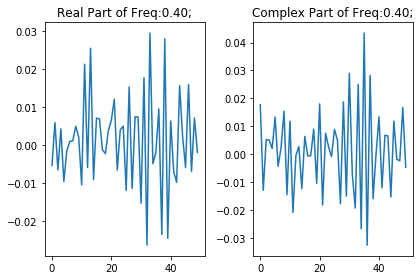

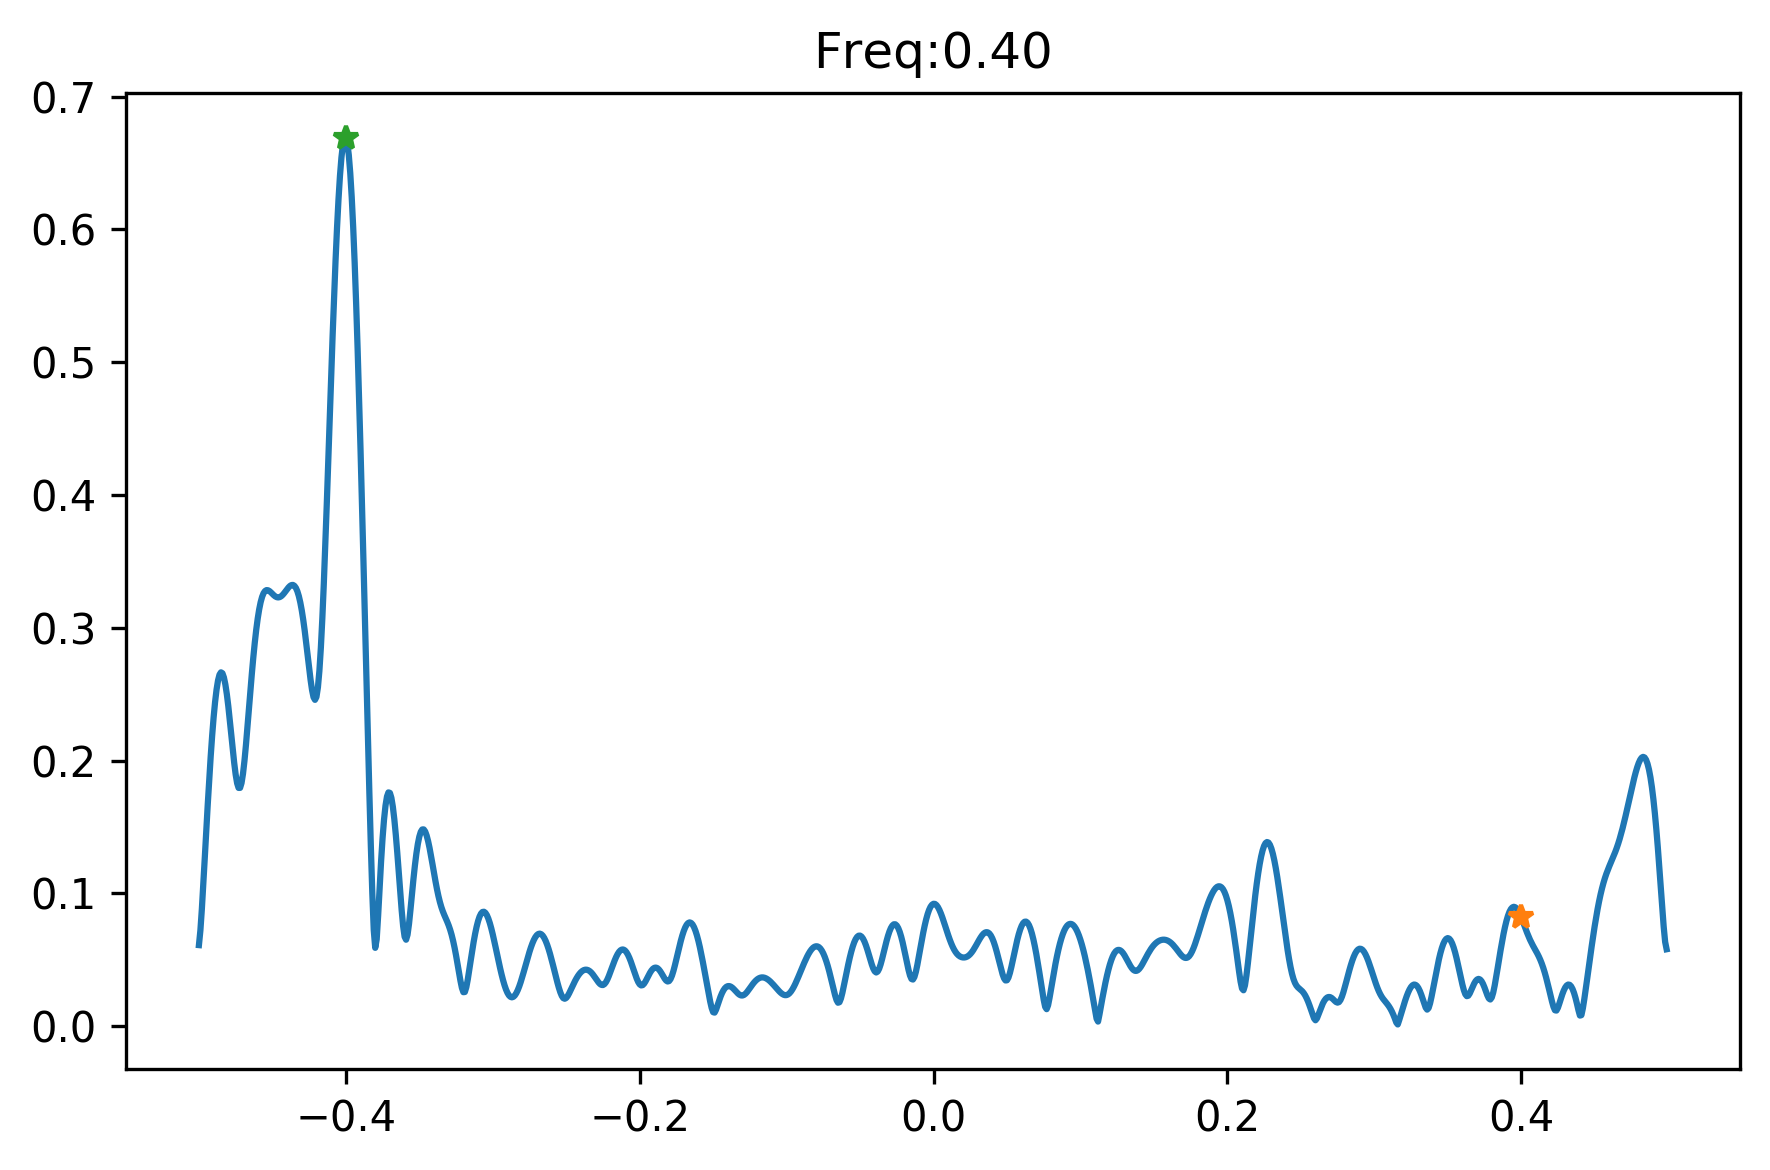

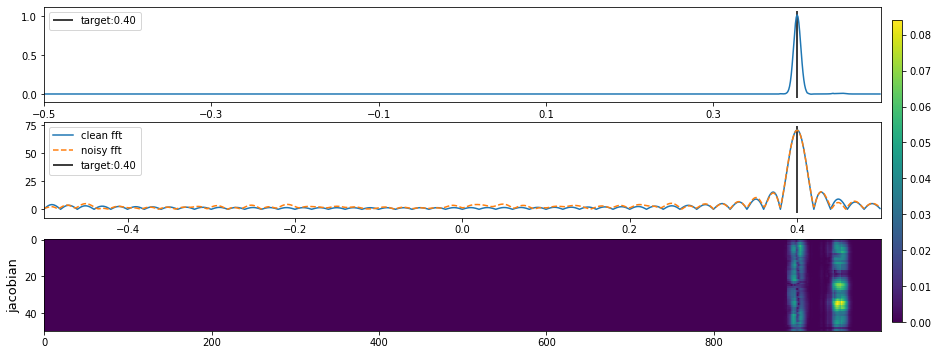

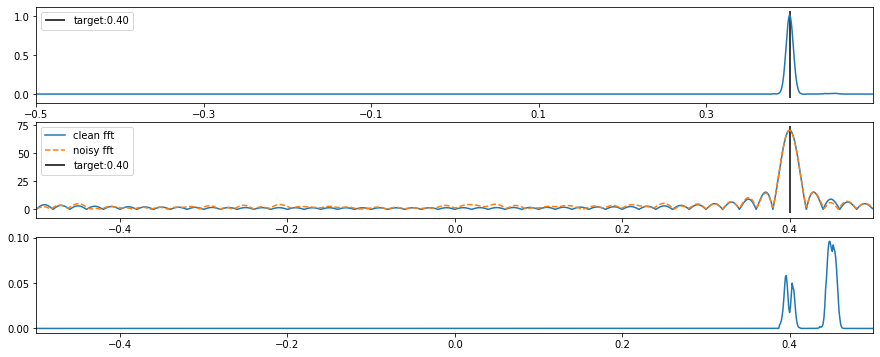

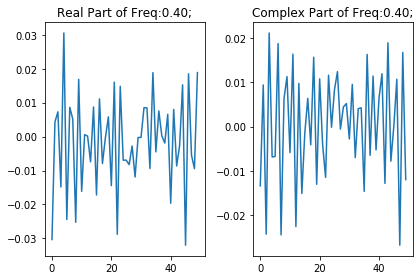

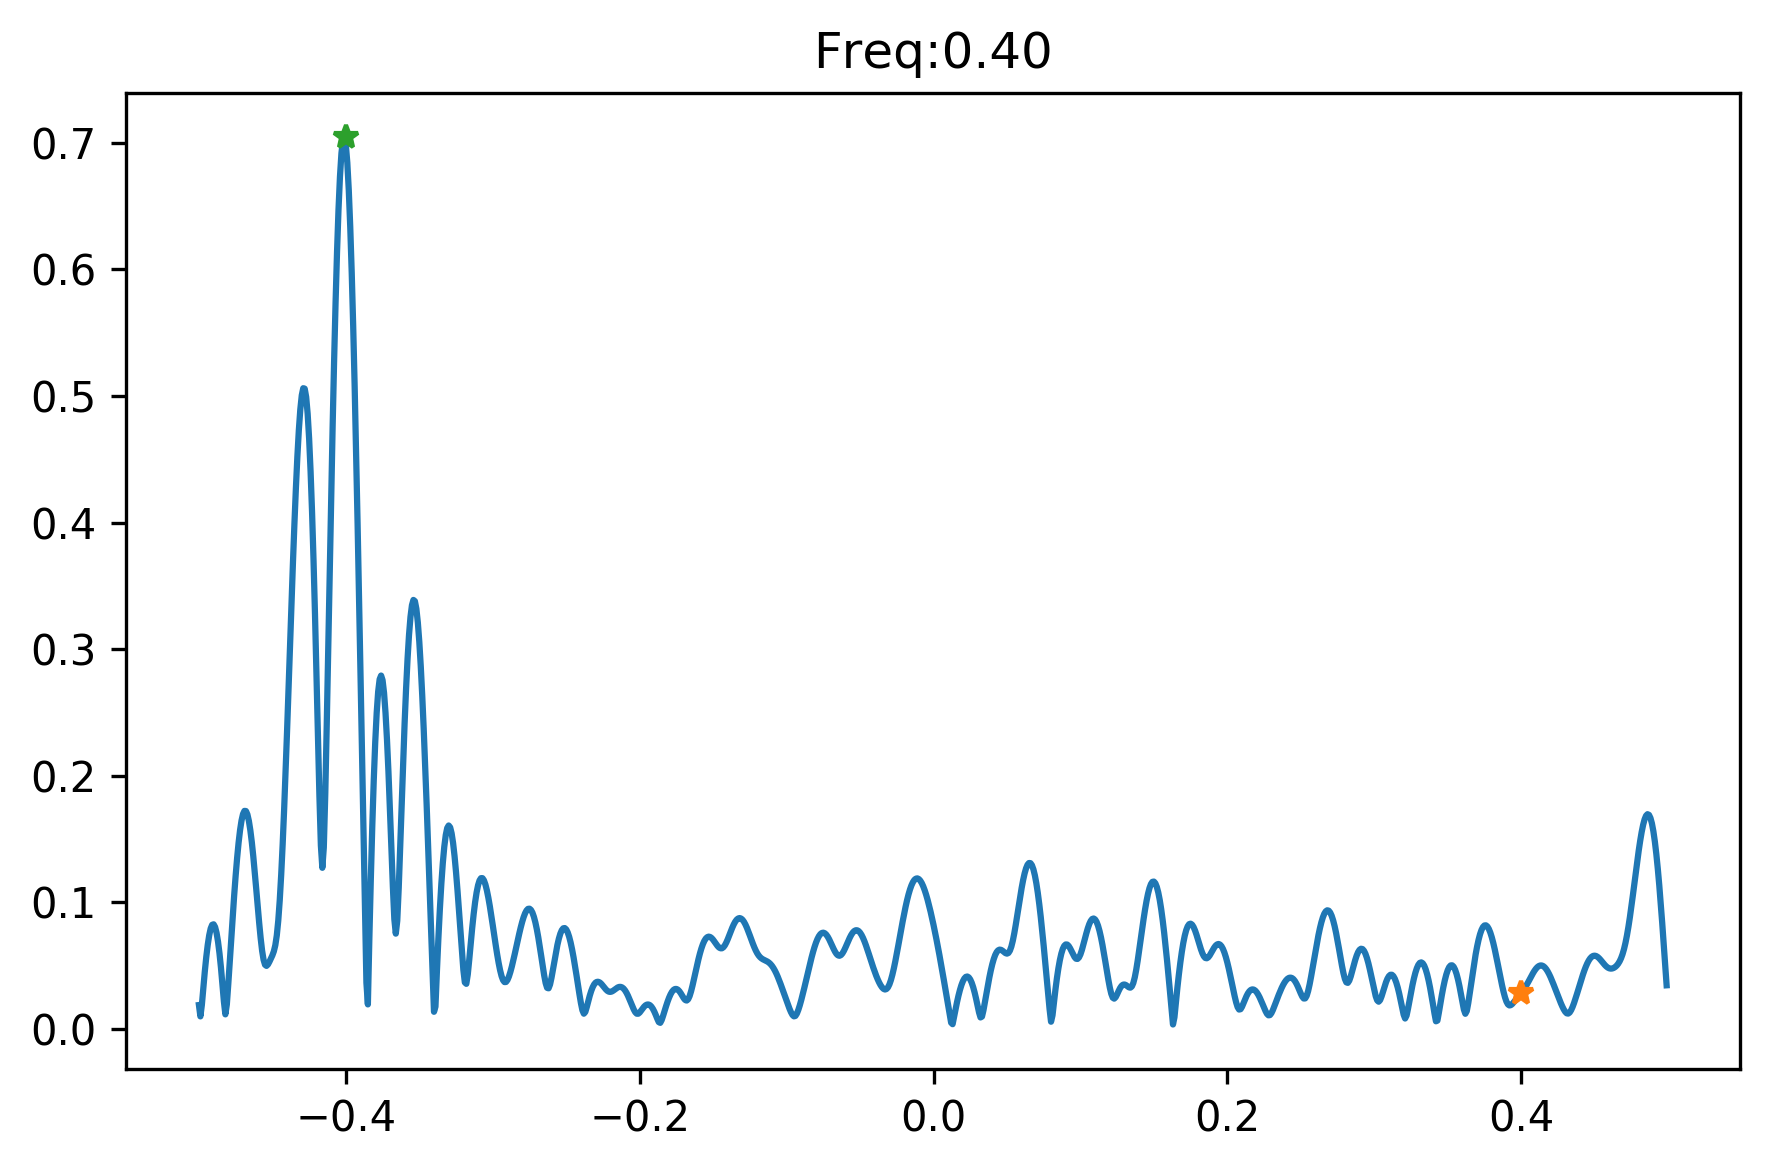

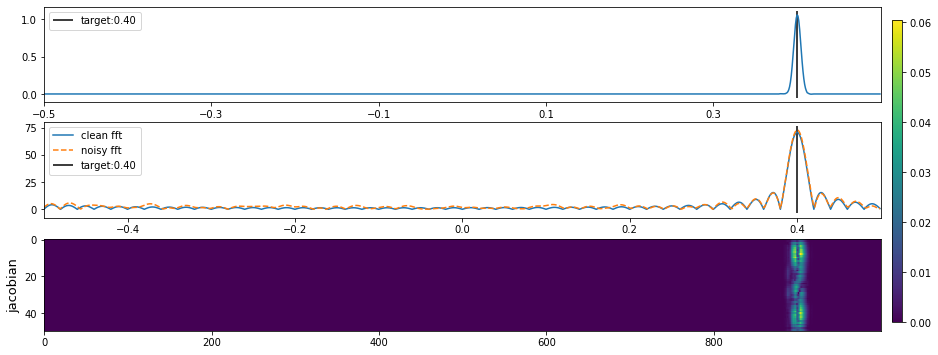

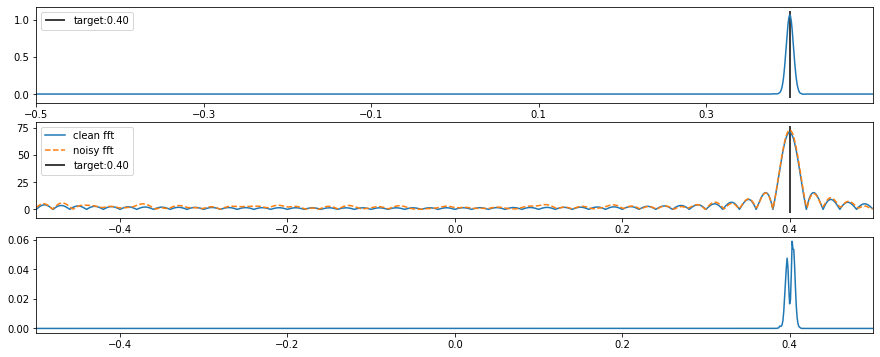

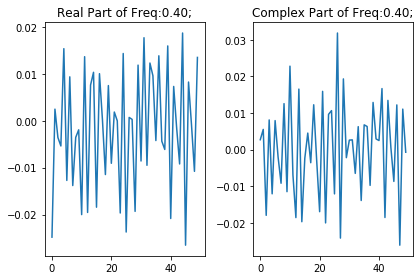

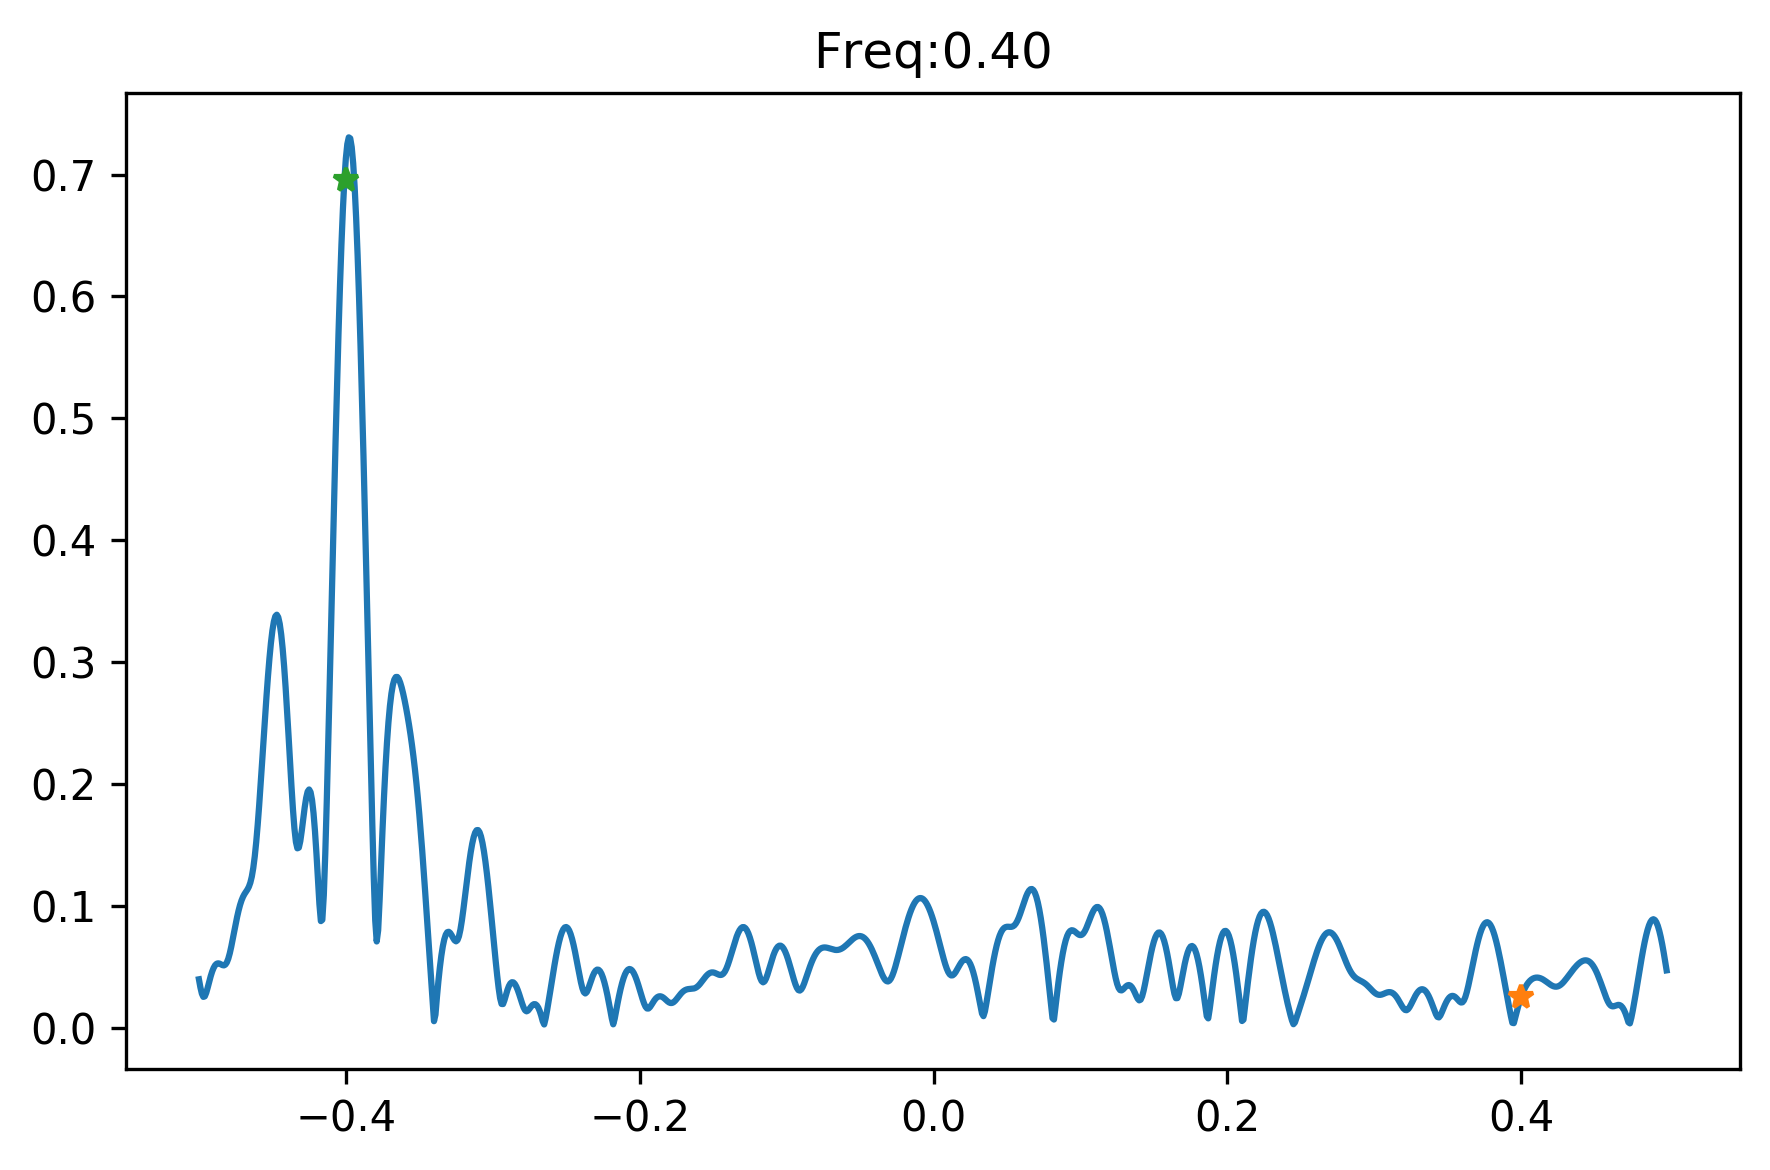

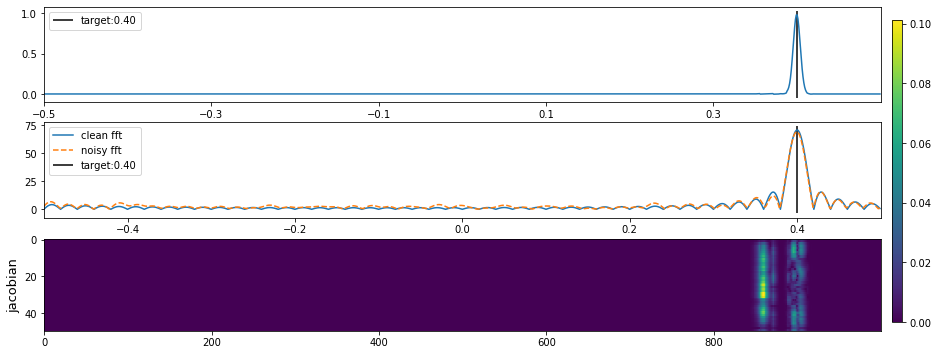

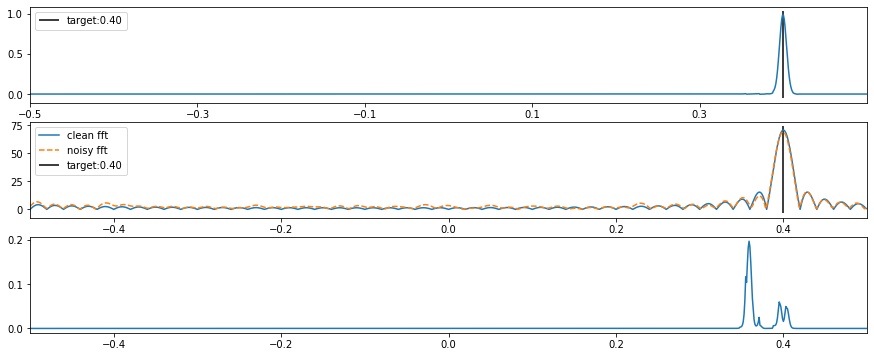

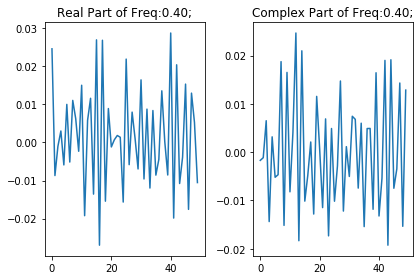

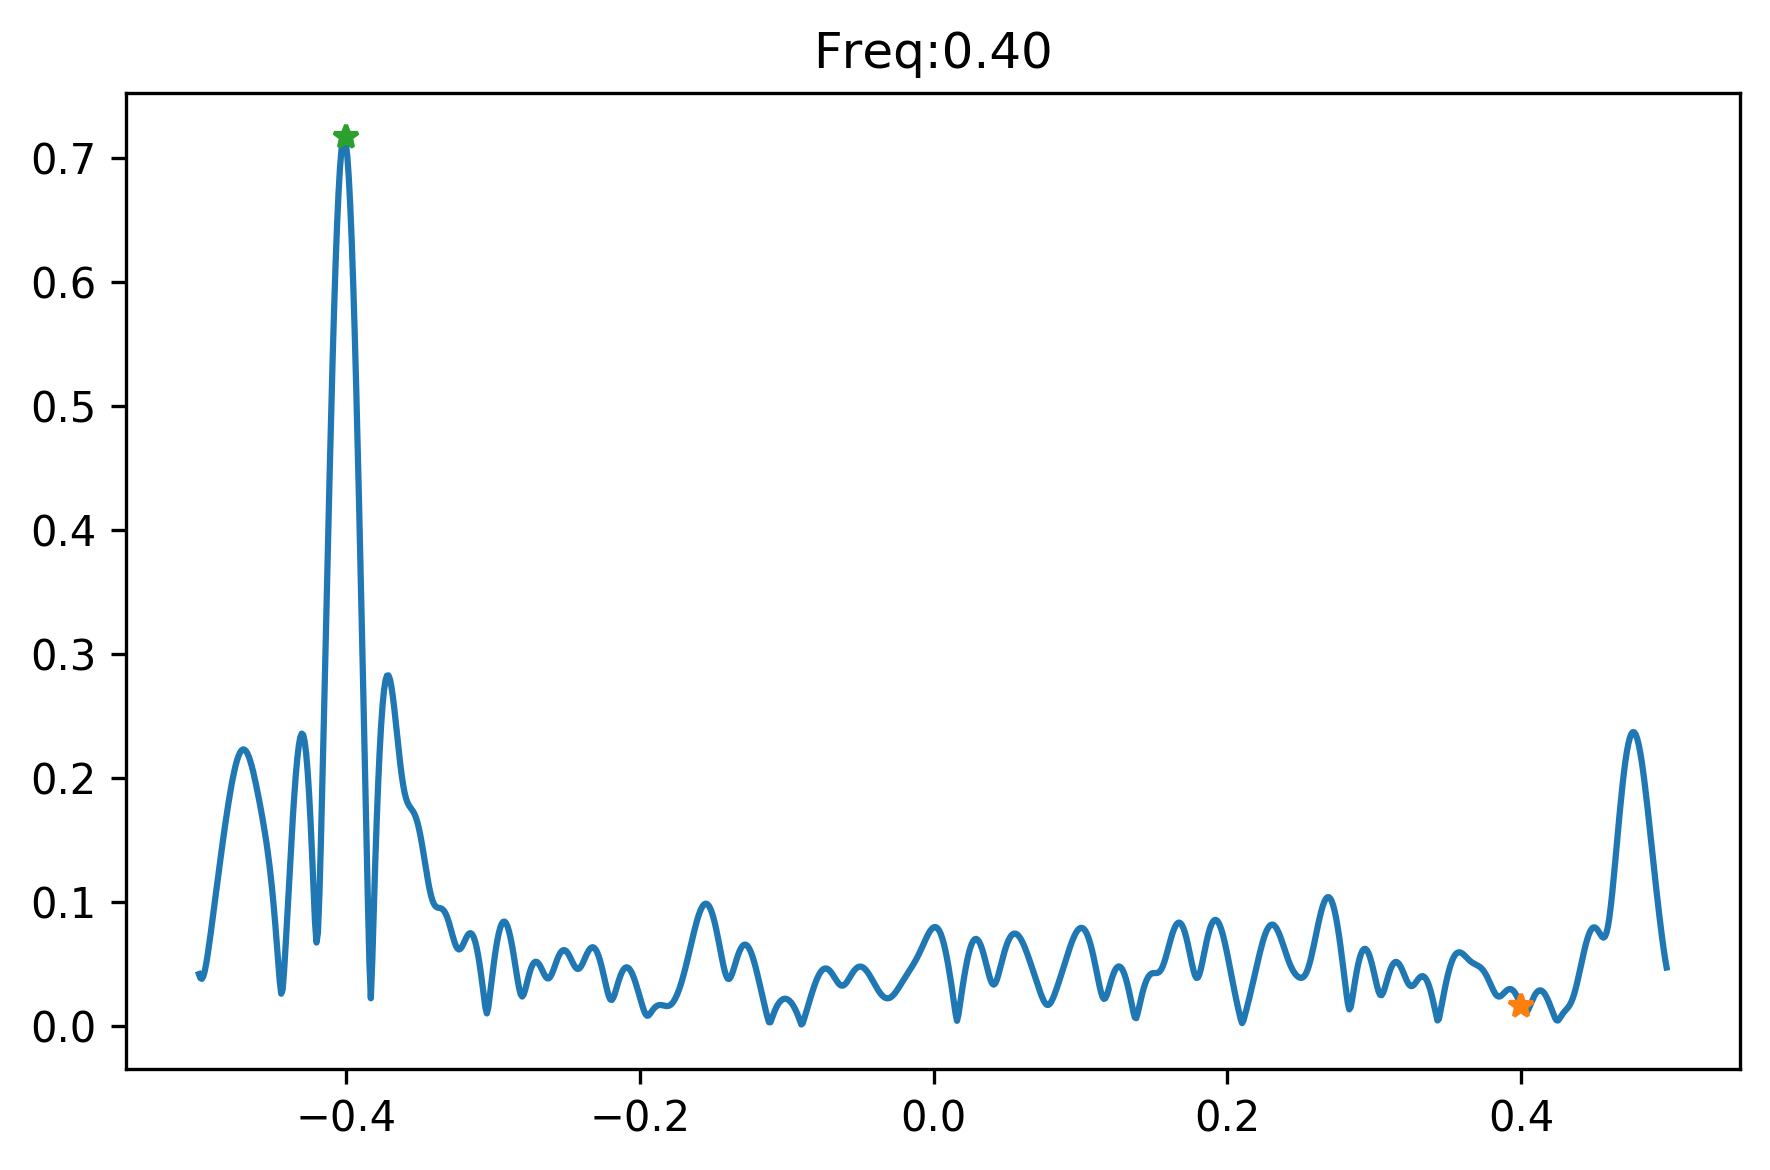

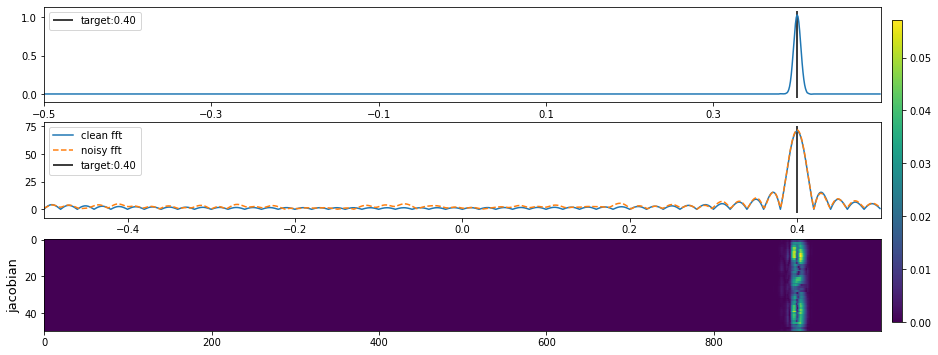

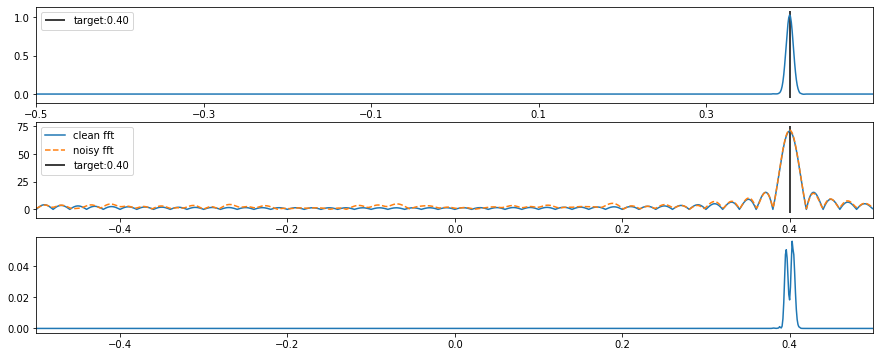

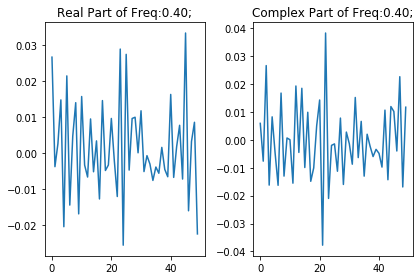

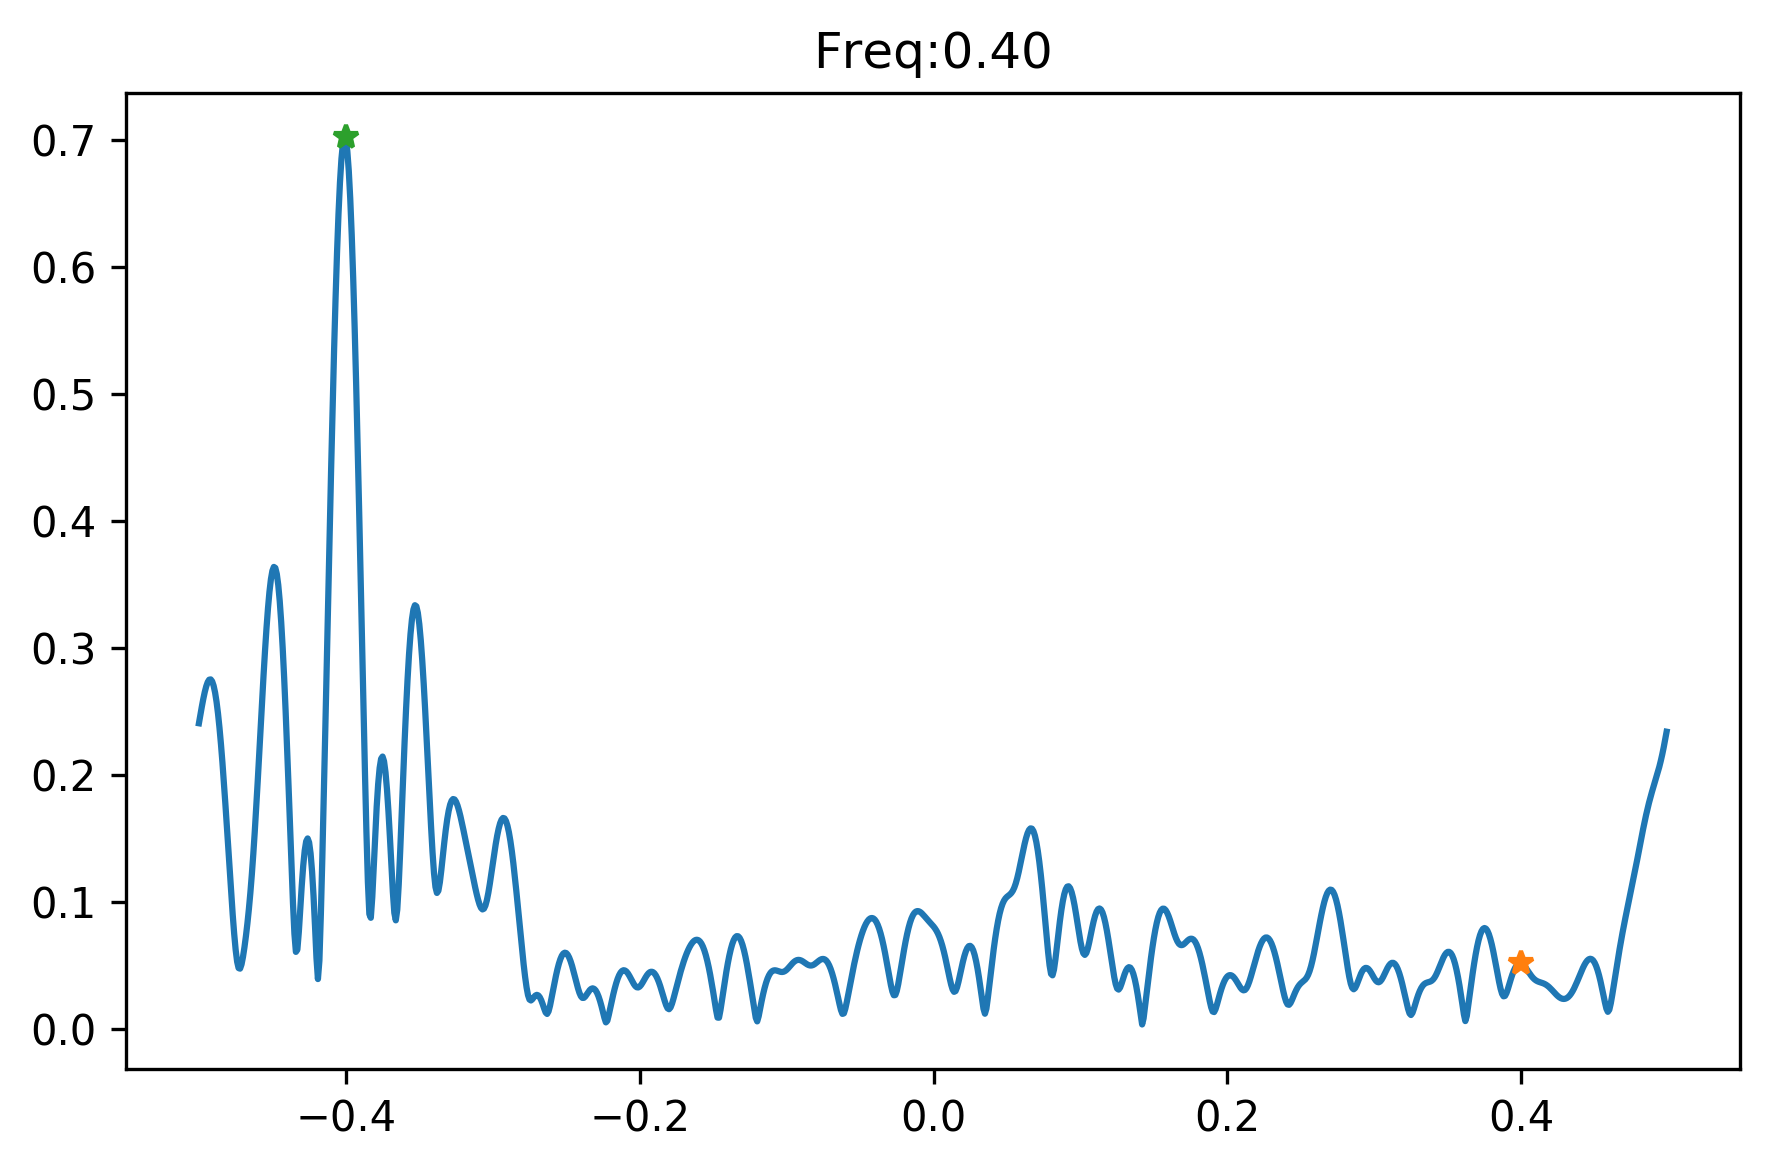

In [119]:
# hyper parameter setting
num_samples=5
signal_dim=50
min_sep=1.
snr=30
fixed_freq = [0.4] # set None for  random frequency
num_freq=len(fixed_freq)
generate_report_plots(num_samples=num_samples,
                      signal_dim=signal_dim,
                      min_sep=min_sep,
                      snr=snr,
                      fixed_freq=fixed_freq,
                      save=True)